# Traffic Prediction
### Final Project for DTSA 5511: Introduction to Deep Learning
#### University of Colorado, Boulder - Master of Science in Data Science

**By:** Andrea Francu  
**Version:** 1.0  
**Date:** February 26, 2025

This project was inspired by the Keras tutorial "Traffic Forecasting Using Graph Neural Networks and LSTM," which caught my attention for its approach to capturing traffic dependencies not only on individual roads but also across neighboring areas. This comprehensive view of traffic modeling highlighted the power of neural networks in handling such complex relationships.

However, my project took a different direction. Instead of using a Graph Neural Network with LSTM, I initially implemented a Transformer model for traffic prediction. This approach proved quite challenging, and I was unable to achieve the level of precision I aimed for. In the end, I transitioned to a simpler MLP model, but I still encountered difficulties with prediction accuracy, managing training times, and conserving GPU resources.

Although inspired by the Keras tutorial, I decided to build my model in PyTorch rather than Keras, incorporating both spatial and temporal data. This choice was driven by my desire to gain hands-on experience with PyTorch, a library I had yet to explore.

In [2]:
# load in necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import keras
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Subset
import optuna
from sklearn.metrics import mean_squared_error
from collections import deque

## Load in the Data
This dataset contains traffic data provided by the California Department of Transportation for district 7 of California. The data was collected from stations along roads that collect speeds of vehicles.
The data for this project was provided by the California Department of Transportation for district 7 of California. The first dataset, distances, is a matrix of roads which contains the distances between the roads. The second dataset, speeds, contains speeds taken throughout the day over several weeks on those same roads. There are 288 roads in both datasets.

In [3]:
# load in and extract zip file from github
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip("PeMSD7_Full.zip")

# make a dataframe for each dataset
distances = pd.read_csv(os.path.join(data_dir, "PeMSD7_W_228.csv"), header=None)
speeds = pd.read_csv(os.path.join(data_dir, "PeMSD7_V_228.csv"), header=None)

29211203/29211203 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
distances.head()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,0.00,3165.94,8731.54,11903.45,7757.18,19878.51,18436.35,2213.47,5887.74,16132.12,...,18457.20,10725.64,9319.97,8273.62,10913.95,21561.83,10012.42,22614.08,26339.90,10012.42
1,3165.94,0.00,5625.76,8749.35,4695.51,16716.96,15274.00,1037.65,2910.29,12966.19,...,17207.37,10422.11,9441.75,8768.21,10565.72,20115.08,9915.24,21118.47,24716.98,9915.24
2,8731.54,5625.76,0.00,3280.12,1035.65,11465.75,10027.42,6659.59,2905.29,7631.76,...,17666.43,13214.26,12923.52,12756.84,13274.36,19981.55,13057.44,20827.51,23992.78,13057.44
3,11903.45,8749.35,3280.12,0.00,4315.55,8193.10,6759.32,9761.19,6171.81,4355.25,...,17482.07,14598.81,14683.19,14783.92,14610.97,19351.79,14634.38,20075.57,22897.82,14634.38
4,7757.18,4695.51,1035.65,4315.55,0.00,12500.86,11062.04,5733.14,1889.16,8667.35,...,17872.58,12942.92,12517.90,12251.20,13019.49,20308.62,12718.08,21186.77,24440.57,12718.08


In [5]:
speeds.head()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.1,66.0,64.6,65.6,67.1,71.9,68.6,67.7,65.8,40.9,...,69.1,70.9,65.0,64.5,66.6,66.6,65.0,69.3,67.7,68.9
1,68.1,66.8,61.7,66.7,64.5,71.6,72.3,64.9,65.6,40.1,...,70.6,65.4,65.0,64.9,65.1,67.7,65.0,67.7,68.8,68.8
2,68.0,64.3,66.6,68.7,68.1,70.5,70.2,61.7,63.4,39.6,...,72.2,70.5,65.0,64.7,66.7,68.9,65.0,70.2,69.1,68.7
3,68.3,67.8,65.9,66.6,67.9,70.3,69.8,67.6,63.2,37.6,...,71.2,69.7,65.0,65.2,67.2,66.9,65.0,70.4,67.3,69.0
4,68.9,69.5,61.2,67.4,64.0,68.1,67.0,66.7,64.2,36.8,...,71.3,65.8,65.0,66.3,66.7,66.2,65.0,68.0,67.4,68.1


## Exploratory Data Analysis (EDA)
### Distances Between Roads
The first dataset contains the distances between 288 roads. This will be useful data for this model as traffic data for some roads can be leveraged to predict traffic in neighboring roads. A natural visualization for this dataset is a heatmap showing the distances between the roads in various shades. The darker areas indicate roads that are near each other

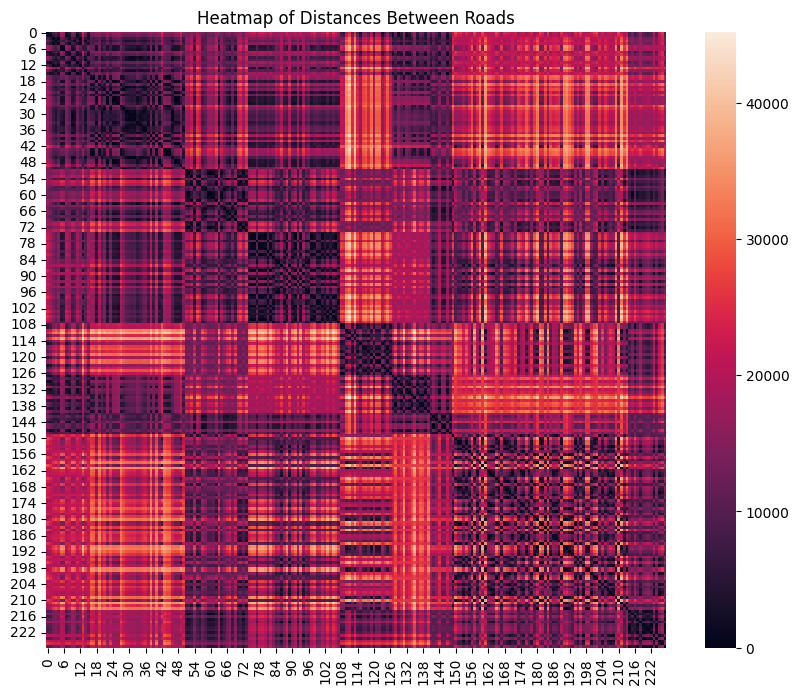

In [6]:
plt.figure(figsize = (10, 8))
sns.heatmap(distances)
plt.title("Heatmap of Distances Between Roads")
plt.show()

### Average Speeds on Roads
The second dataset contains the 228 roads as columns, with various times as the rows and the speed of vehicles on that road at that time filled in. The speeds are recorded in 5 minute increments. We can update this to be in 1 minute increments by multiplying by 5. Then we can look at a time series plot of these speeds and a boxplot of the distribution of speeds.

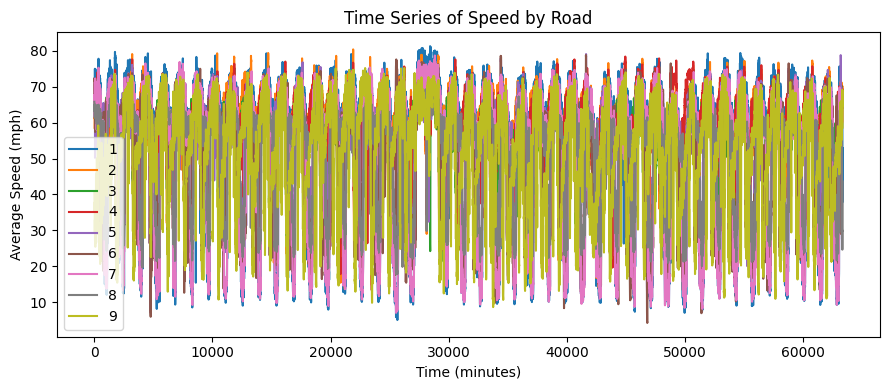

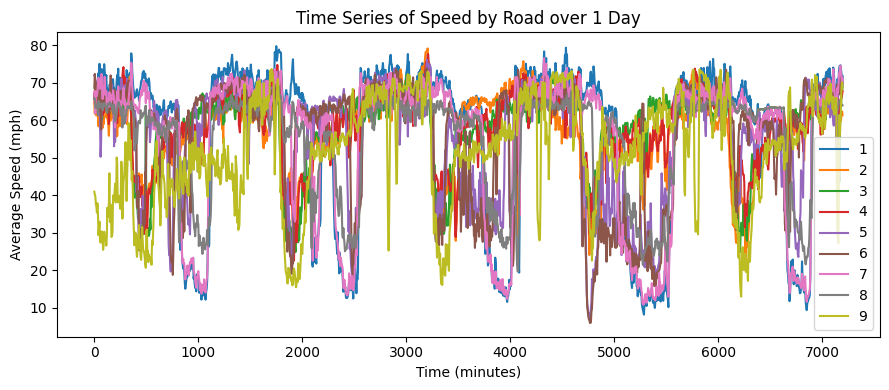

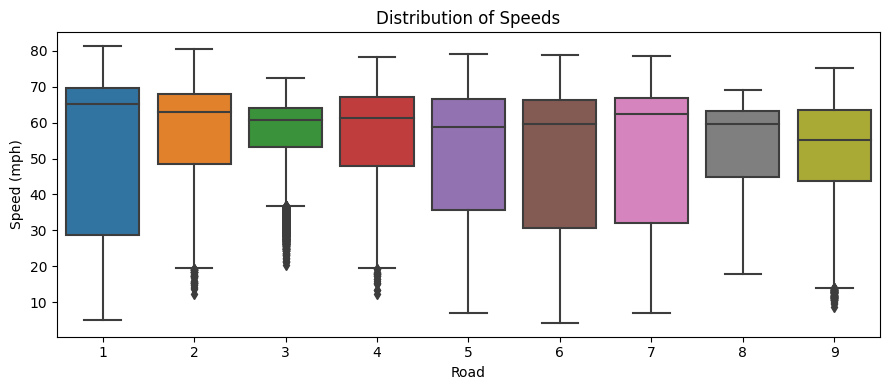

In [7]:
speeds.index = speeds.index * 5 # multiply by 5 to get into minutes
speeds_subset = speeds.iloc[:, 1:10] # choose subset of first 10 roads for visualization

# time series speeds plot
plt.figure(figsize = (9, 4))

for road in speeds_subset:
    plt.plot(speeds_subset[road], label = road)
    
plt.title('Time Series of Speed by Road')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Speed (mph)')
plt.legend()
plt.tight_layout()
plt.show()

# time series plot for speeds over 1 day
one_day = speeds.iloc[:1440, 1:10] # take first 10 roads and first day (1440 minutes)
plt.figure(figsize = (9, 4))

for road in one_day:
    plt.plot(one_day[road], label = road)
    
plt.title('Time Series of Speed by Road over 1 Day')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Speed (mph)')
plt.legend()
plt.tight_layout()
plt.show()

# boxplot of distribution of speeds
plt.figure(figsize = (9, 4))
sns.boxplot(data = speeds_subset)
plt.title('Distribution of Speeds')
plt.ylabel('Speed (mph)')
plt.xlabel('Road')
plt.tight_layout()
plt.show()

As we can see in the first plot, there is a general fluctuation of speed/traffic each day, but when looking more closely over one specific day, we see some more variety across different roads. We also see this variety in the boxplots. The roads generally have a similar mean speed but the lower range can vary pretty dramatically.
## Data Preparation
Before we can begin modeling, several steps must be taken to prepare the data for use. First, the raw distance data needs to be normalized to a scale of 0 to 1. Additionally, we must ensure the data is properly shaped and converted into a format suitable for PyTorch. Lastly, we split the data into training and validation sets and set up efficient data loaders for batch processing.

In [8]:
road_ids = [f"road_{i}" for i in range(distances.shape[0])] # create a list of road names (road_0, road_1, etc.)

# convert distance matrix to a pandas dataframe with road names as labels
distances_df = pd.DataFrame(distances.values, index=road_ids, columns=road_ids)

# reshape the distance matrix from wide to long format
distances_melted = distances_df.reset_index().melt(
    id_vars=['index'],  # keep the road_id column
    var_name='road_id2',  # name for the second road id
    value_name='distance'  # name for the distance values
)

distances_melted.rename(columns={'index': 'road_id1'}, inplace=True) # rename first road id column

# scale all distances to be between 0 and 1
distances_melted['distance_normalized'] = distances_melted['distance'] / distances_melted['distance'].max()
# reshape back to matrix form, now with normalized values
distances_matrix = distances_melted.pivot(
    index='road_id1', 
    columns='road_id2', 
    values='distance_normalized'
)

# prepare speed data
speeds = speeds.reset_index(drop=True)  # reset index to get consecutive numbers
speeds['time_idx'] = speeds.index  # create time index column
road_ids = [f"road_{i}" for i in range(speeds.shape[1] - 1)]  # create road ids
# reshape speeds from wide (each road is a column) to long format (each row is a time-road combo)
speeds_melted = speeds.melt(id_vars='time_idx', var_name='road_id', value_name='speed')
# add 'road_' prefix to road ids to match distance matrix format
speeds_melted['road_id'] = 'road_' + speeds_melted['road_id'].astype(str)

selected_road_ids = road_ids[:30]  # use only first 30 roads to speed up training

# split the data
training_cutoff = int(speeds_melted['time_idx'].max() * 0.8)
train_data = speeds_melted[speeds_melted['time_idx'] <= training_cutoff]
val_data = speeds_melted[speeds_melted['time_idx'] > training_cutoff]

# filter train and validation data to only include selected roads
train_data = train_data[train_data['road_id'].isin(selected_road_ids)]
val_data = val_data[val_data['road_id'].isin(selected_road_ids)]

# create training dataset with three components:
train_dataset = torch.utils.data.TensorDataset(
   torch.FloatTensor(train_data['time_idx'].values),  # time values
   torch.LongTensor([int(r.split('_')[1]) for r in train_data['road_id']]),  # road ids (numbers only)
   torch.FloatTensor(train_data['speed'].values)  # speed values
)

# same for validation dataset 
val_dataset = torch.utils.data.TensorDataset(
   torch.FloatTensor(val_data['time_idx'].values),  # time values
   torch.LongTensor([int(r.split('_')[1]) for r in val_data['road_id']]),  # road ids (numbers only)
   torch.FloatTensor(val_data['speed'].values)  # speed values
)

BATCH_SIZE = 64
WORKERS = 2

# create data loaders that will handle batching
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS, 
    pin_memory=False 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=False
)

## Model Architecture
Initially, I implemented a Temporal Fusion Transformer, but it wasn’t suitable for incorporating spatial data as it focused only on temporal data. I then moved to a custom transformer with time and distance embeddings, using distances as attention weights. After several days of effort without good results, I switched to a simpler MLP model with batch normalization, ReLU, and dropout layers. I encountered issues with training time and freezing, so I reduced the problem scope by using only 50 of the 288 roads, which sped up training. However, I ran out of GPU time and couldn't fine-tune as much as I hoped.

I developed the TrafficModel as a PyTorch Lightning module to use Optuna for hyperparameter tuning, implementing road embeddings and an MLP structure. The model tracks key metrics efficiently, and I optimized memory usage by managing GPU resources. Though I couldn’t fully refine the model, this setup allowed for experimentation with various architectures and monitoring of performance.

In [9]:
class TrafficModel(pl.LightningModule):
    # starting hyperparameters - to be adjusted after tuning 
    def __init__(self, n_roads, d_model=32, n_heads=8, n_layers=2, learning_rate=0.01):
        super().__init__()
        self.learning_rate = learning_rate
        
        # road embeddings
        self.road_embedding = nn.Embedding(n_roads, d_model)
        
        # MLP network
        self.layers = nn.Sequential(
            nn.Linear(d_model + 1, d_model*2),  # +1 for time input
            nn.BatchNorm1d(d_model*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model*2, d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )
        
        self.n_roads = n_roads
        
        # use collections.deque to limit memory usage for metrics
        self.metrics = {
            'val_loss': deque(maxlen=10),
            'pred_variance': deque(maxlen=10), 
            'pred_min': deque(maxlen=10), 
            'pred_max': deque(maxlen=10), 
            'actual_min': deque(maxlen=10), 
            'actual_max': deque(maxlen=10)
        }
        
        # store epoch metrics in lists for plotting
        self.epoch_metrics = {
            'train_loss': [],
            'val_loss': [],
            'pred_min': [], 
            'pred_max': [], 
            'actual_min': [], 
            'actual_max': []
        }
    
    def forward(self, time, road_ids):
        # simple time feature (just normalized time)
        time_normalized = (time / 1440.0).unsqueeze(1)  # normalize by minutes in day
        
        # road embedding
        road_emb = self.road_embedding(road_ids)
        
        # combine features
        combined = torch.cat([road_emb, time_normalized], dim=1)
        
        # predict speed
        return self.layers(combined).squeeze(-1)
    
    def training_step(self, batch, batch_idx):
        time, roads, y = batch
        y_hat = self(time, roads)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        
        return loss
    
    # repeat for validation
    def validation_step(self, batch, batch_idx):
        time, roads, y = batch
        y_hat = self(time, roads)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        
        # store predictions and actuals
        self.pred_vals = y_hat.detach().cpu()
        self.actual_vals = y.detach().cpu()
        
        return {'loss': loss, 'preds': y_hat, 'targets': y}
        
    def on_train_epoch_end(self):
        # store train loss
        train_loss = self.trainer.callback_metrics.get('train_loss', torch.tensor(0.0)).item()
        self.epoch_metrics['train_loss'].append(train_loss)
        
        # print train metrics
        print(f"Epoch {self.current_epoch}: train_loss = {train_loss:.4f}")
        
        # free memory at the end of each training epoch
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    def on_validation_epoch_end(self):
        # get validation metrics
        val_loss = self.trainer.callback_metrics.get('val_loss', torch.tensor(0.0)).item()
        
        # calculate statistics on last batch
        pred_min = float(self.pred_vals.min())
        pred_max = float(self.pred_vals.max())
        actual_min = float(self.actual_vals.min())
        actual_max = float(self.actual_vals.max())
        
        # store metrics
        self.metrics['val_loss'].append(val_loss)
        self.metrics['pred_min'].append(pred_min)
        self.metrics['pred_max'].append(pred_max)
        self.metrics['actual_min'].append(actual_min)
        self.metrics['actual_max'].append(actual_max)
        
        # also store in epoch metrics for plotting
        self.epoch_metrics['val_loss'].append(val_loss)
        self.epoch_metrics['pred_min'].append(pred_min)
        self.epoch_metrics['pred_max'].append(pred_max)
        self.epoch_metrics['actual_min'].append(actual_min)
        self.epoch_metrics['actual_max'].append(actual_max)
        
        # print metrics
        print(f"Epoch {self.current_epoch}: val_loss = {val_loss:.4f}")
        print(f"  Predictions: min = {pred_min:.2f}, max = {pred_max:.2f}")
        print(f"  Actuals: min = {actual_min:.2f}, max = {actual_max:.2f}")
        
        # free memory at the end of validation too
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        optimizer.zero_grad() # make sure optimizer zeros gradients properly
        return optimizer

## Hyperparameter Tuning
This code is using Optuna, a hyperparameter optimization framework, to tune the parameters of the TrafficModel. The objective function defines how to suggest and evaluate different sets of hyperparameters to find the best combination that minimizes the training loss. This works by inputting several options for hyperparameters, and Optuna uses an efficient and informed method to choose the best combination. Rather than checking every combination, which would take an extremely long time, it uses a sampling method to pick which combinations to test and adapts the next test based on previous results. Another method to save time is only using 5% of the training data to perform the hyperparameter tuning.

In [33]:
def objective(trial):
    
    # parameters we want to optimize
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),  # search learning rate on log scale for better coverage
        'd_model': trial.suggest_int('d_model', 16, 128, step=8),  # embedding dimension in steps of 8
        'n_heads': trial.suggest_int('n_heads', 2, 8, step=2),  # number of attention heads (only even numbers)
        'n_layers': trial.suggest_int('n_layers', 1, 3)  # number of layers in the network
    }
    
    model = TrafficModel(n_roads=len(road_ids), **params) # create model
    
    # initialize weights
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    print(f"trial {trial.number}: testing parameters {params}") # debugging line to see if script is actually freezing

    trainer = pl.Trainer(
        max_epochs=10,  # limit training time per trial
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=3),  # stop early if not improving for 3 epochs
        ],
        gradient_clip_val=0.1,  # prevent exploding gradients
        enable_progress_bar=True, 
        logger=False  # disable tensorboard logging during optimization
    )

    try:
        # create a smaller subset of training data for faster hyperparameter search
        subset_size = int(0.1 * len(train_dataset))  # use 10% of data for speed
        subset_indices = torch.randperm(len(train_dataset))[:subset_size]  # random sampling without replacement
        train_subset = torch.utils.data.Subset(train_dataset, subset_indices)
        
        # create a dataloader for the subset with appropriate batch size
        train_subset_loader = DataLoader(
            train_subset, 
            batch_size=128,  # larger batch for faster training
            shuffle=True,  # shuffle data for better generalization
            num_workers=0  # parallel data loading
        )
        
        # train the model with current hyperparameters
        trainer.fit(model, train_subset_loader, val_loader)
        
        # extract validation loss for optimization objective
        val_loss = trainer.callback_metrics.get('val_loss')
        
        # handle any NaN values (sign of unstable training)
        if val_loss is None or torch.isnan(val_loss).any():
            print(f"trial {trial.number} produced NaN loss - skipping")
            return float('inf')  # return infinity so optuna will avoid these parameters
        
        # return validation loss as the optimization target
        return val_loss.item()
    
    except Exception as e:
        # error handling to debug failed trials
        print(f"error in trial {trial.number}: {e}")
        print(f"parameters that caused error: {params}")
        return float('inf')  # return infinity to skip this parameter set

# create study object for hyperparameter optimization
study = optuna.create_study(direction="minimize")  # we want to minimize validation loss

# run optimization for 10 trials
study.optimize(objective, n_trials=10)  # adjust number of trials based on time constraints

# print results of hyperparameter search
print("\nbest parameters found:")
for param_name, param_value in study.best_params.items():
    print(f"  {param_name}: {param_value}")
print(f"best validation loss: {study.best_value:.6f}")

[I 2025-02-26 06:26:00,993] A new study created in memory with name: no-name-7c7a91e4-cd3f-4575-bae9-49c746fb2327


trial 0: testing parameters {'learning_rate': 1.2894292977612454e-05, 'd_model': 120, 'n_heads': 8, 'n_layers': 2}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:27:51,556] Trial 0 finished with value: 2904.292236328125 and parameters: {'learning_rate': 1.2894292977612454e-05, 'd_model': 120, 'n_heads': 8, 'n_layers': 2}. Best is trial 0 with value: 2904.292236328125.


trial 1: testing parameters {'learning_rate': 0.00010377702738227962, 'd_model': 40, 'n_heads': 4, 'n_layers': 2}


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:29:42,840] Trial 1 finished with value: 1707.5638427734375 and parameters: {'learning_rate': 0.00010377702738227962, 'd_model': 40, 'n_heads': 4, 'n_layers': 2}. Best is trial 1 with value: 1707.5638427734375.


trial 2: testing parameters {'learning_rate': 0.0002449683558175448, 'd_model': 16, 'n_heads': 8, 'n_layers': 3}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:31:31,651] Trial 2 finished with value: 1209.9241943359375 and parameters: {'learning_rate': 0.0002449683558175448, 'd_model': 16, 'n_heads': 8, 'n_layers': 3}. Best is trial 2 with value: 1209.9241943359375.


trial 3: testing parameters {'learning_rate': 0.0004637599534709456, 'd_model': 48, 'n_heads': 6, 'n_layers': 2}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:33:01,947] Trial 3 finished with value: 183.46832275390625 and parameters: {'learning_rate': 0.0004637599534709456, 'd_model': 48, 'n_heads': 6, 'n_layers': 2}. Best is trial 3 with value: 183.46832275390625.


trial 4: testing parameters {'learning_rate': 0.0009772770710998612, 'd_model': 80, 'n_heads': 6, 'n_layers': 2}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:34:54,209] Trial 4 finished with value: 176.25950622558594 and parameters: {'learning_rate': 0.0009772770710998612, 'd_model': 80, 'n_heads': 6, 'n_layers': 2}. Best is trial 4 with value: 176.25950622558594.


trial 5: testing parameters {'learning_rate': 0.00010668548908219594, 'd_model': 64, 'n_heads': 6, 'n_layers': 3}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:36:45,221] Trial 5 finished with value: 1311.581298828125 and parameters: {'learning_rate': 0.00010668548908219594, 'd_model': 64, 'n_heads': 6, 'n_layers': 3}. Best is trial 4 with value: 176.25950622558594.


trial 6: testing parameters {'learning_rate': 3.402396951257157e-05, 'd_model': 40, 'n_heads': 2, 'n_layers': 3}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:38:39,243] Trial 6 finished with value: 2873.787841796875 and parameters: {'learning_rate': 3.402396951257157e-05, 'd_model': 40, 'n_heads': 2, 'n_layers': 3}. Best is trial 4 with value: 176.25950622558594.


trial 7: testing parameters {'learning_rate': 2.084234761876944e-05, 'd_model': 88, 'n_heads': 8, 'n_layers': 2}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:40:29,851] Trial 7 finished with value: 2808.270751953125 and parameters: {'learning_rate': 2.084234761876944e-05, 'd_model': 88, 'n_heads': 8, 'n_layers': 2}. Best is trial 4 with value: 176.25950622558594.


trial 8: testing parameters {'learning_rate': 0.0007151251551955705, 'd_model': 56, 'n_heads': 8, 'n_layers': 1}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:42:21,650] Trial 8 finished with value: 176.92005920410156 and parameters: {'learning_rate': 0.0007151251551955705, 'd_model': 56, 'n_heads': 8, 'n_layers': 1}. Best is trial 4 with value: 176.25950622558594.


trial 9: testing parameters {'learning_rate': 0.0008026828796414027, 'd_model': 48, 'n_heads': 8, 'n_layers': 3}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-02-26 06:44:14,767] Trial 9 finished with value: 183.4648895263672 and parameters: {'learning_rate': 0.0008026828796414027, 'd_model': 48, 'n_heads': 8, 'n_layers': 3}. Best is trial 4 with value: 176.25950622558594.



best parameters found:
  learning_rate: 0.0009772770710998612
  d_model: 80
  n_heads: 6
  n_layers: 2
best validation loss: 176.259506


In [19]:
# saved best params to avoid rerunning hyperperameter optimization
best_params = {
    'learning_rate': 0.0009772770710998612,
    'd_model': 80,
    'n_heads': 6,
    'n_layers': 2
}

# train final model with best combination of parameters
# final_model = TrafficModel(n_roads=len(road_ids), **study.best_params)
final_model = TrafficModel(n_roads=len(road_ids), **best_params)

# initialize weights for better convergence
for p in final_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p, gain=1.5)  

# set up trainer
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=10, # limit number of epochs - freezes around 8 normally
    gradient_clip_val=0.05,  # gradient clipping for stability
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="val_loss", patience=4),  # stop early if not improving
    ],
    log_every_n_steps=10,
    enable_model_summary=True
)

# fit the  model
print("Starting training...")
trainer.fit(final_model, train_loader, val_loader)
print(f"Training completed after {trainer.current_epoch+1} epochs")

Starting training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: val_loss = 2705.0547
  Predictions: min = 0.93, max = 0.94
  Actuals: min = 22.40, max = 68.70


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: val_loss = 203.6073
  Predictions: min = 56.10, max = 56.13
  Actuals: min = 60.60, max = 64.60
Epoch 0: train_loss = 188.5907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: val_loss = 199.2517
  Predictions: min = 51.70, max = 51.72
  Actuals: min = 60.60, max = 64.60
Epoch 1: train_loss = 205.9953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: val_loss = 198.9213
  Predictions: min = 49.62, max = 49.64
  Actuals: min = 60.60, max = 64.60
Epoch 2: train_loss = 140.0177


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: val_loss = 199.1094
  Predictions: min = 47.48, max = 47.49
  Actuals: min = 60.60, max = 64.60
Epoch 3: train_loss = 253.5728


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: val_loss = 196.4754
  Predictions: min = 50.75, max = 50.77
  Actuals: min = 60.60, max = 64.60
Epoch 4: train_loss = 204.2116


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: val_loss = 197.3832
  Predictions: min = 48.53, max = 48.55
  Actuals: min = 60.60, max = 64.60
Epoch 5: train_loss = 160.0983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: val_loss = 199.4022
  Predictions: min = 49.68, max = 49.70
  Actuals: min = 60.60, max = 64.60
Epoch 6: train_loss = 141.2160


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: val_loss = 198.3608
  Predictions: min = 47.42, max = 47.43
  Actuals: min = 60.60, max = 64.60
Epoch 7: train_loss = 138.3621


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: val_loss = 197.6469
  Predictions: min = 48.90, max = 48.92
  Actuals: min = 60.60, max = 64.60
Epoch 8: train_loss = 151.4477
Training completed after 10 epochs


## Results and Analysis
Now that our hyperparemeters are tuned and the model is trained, we can take a look at how well it performed. From first glance at the metrics that printed out it looks like there is a big improvement from the first epoch to the next. However, it looks like the model then just continutes to predict values around 40-50. 

In [18]:
final_model.eval()
with torch.no_grad():
    # get all predictions
    all_preds = []
    all_actuals = []
    
    for batch in val_loader:
        time, roads, y = batch
        y_hat = final_model(time, roads)
        all_preds.append(y_hat)
        all_actuals.append(y)
    
    # combine batches
    all_preds = torch.cat(all_preds)
    all_actuals = torch.cat(all_actuals)
    
    # print results
    print(f"Predictions range: {all_preds.min().item():.2f} to {all_preds.max().item():.2f}")
    print(f"Actuals range: {all_actuals.min().item():.2f} to {all_actuals.max().item():.2f}")
    print(f"MSE: {nn.functional.mse_loss(all_preds, all_actuals).item():.2f}")

Predictions range: 43.42 to 63.96
Actuals range: 3.80 to 79.40
MSE: 199.05


Even though the actual data is ranging from 3 to 80 mph, the model is consistently choosing a value in the middle of this with every model I have tried. The next bit of code evaluates the model on the validation set by predicting traffic speeds and comparing them with the actual values. 

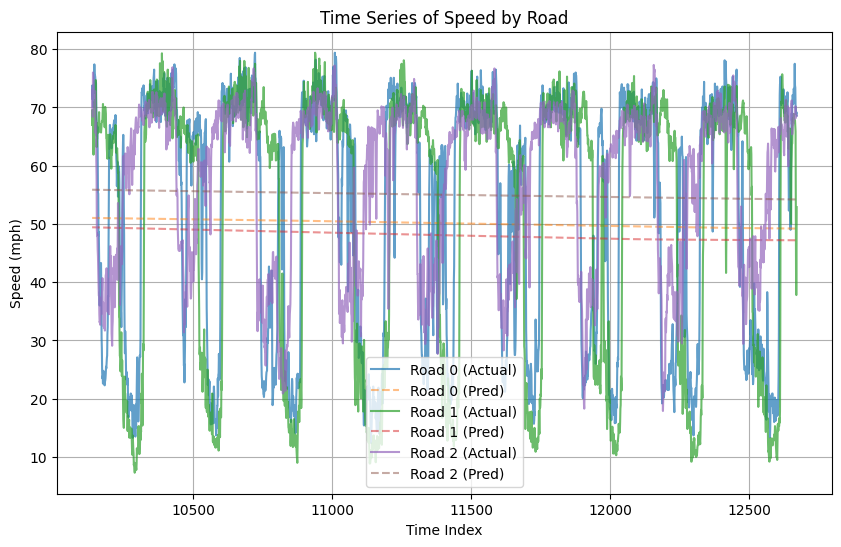

In [17]:
# collect predictions for specific roads
roads_to_plot = [0, 1, 2]  # first 3 roads
road_data = {road_id: {'time': [], 'actual': [], 'pred': []} for road_id in roads_to_plot}

# evaluate and collect data for specific roads
with torch.no_grad():
    for batch in val_loader:
        time, roads, y = batch
        y_hat = final_model(time, roads)
        
        # store data for selected roads
        for i, road_id in enumerate(roads):
            if road_id.item() in roads_to_plot:
                road_data[road_id.item()]['time'].append(time[i].item())
                road_data[road_id.item()]['actual'].append(y[i].item())
                road_data[road_id.item()]['pred'].append(y_hat[i].item())

# plot for selected roads
plt.figure(figsize=(10, 6))
for road_id in roads_to_plot:
    plt.plot(road_data[road_id]['time'], road_data[road_id]['actual'], 
             label=f'Road {road_id} (Actual)', alpha=0.7)
    plt.plot(road_data[road_id]['time'], road_data[road_id]['pred'], 
             linestyle='--', label=f'Road {road_id} (Pred)', alpha=0.5)

plt.title('Time Series of Speed by Road')
plt.xlabel('Time Index')
plt.ylabel('Speed (mph)')
plt.legend()
plt.grid(True)
plt.show()

The model is clearly strugglign to find meaningful patterns that are there. It seems to be consistently choosing a value around the median or mean of the speeds rather than actually predicting according to the pattern. After a lot of time spent on many different models, layer adjustment, hyperparameter tuning, preprocessing changes, I was not able to come up with a model that could find these patterns unfortunately.

## Conclusion
Overall, this project was a challenging endeavor, and I don't feel like I found the ideal solution. With more time, resources, and research, I believe I could have developed a higher-performing model. One of my biggest regrets is not being able to effectively incorporate the distances between roads, which was the primary motivation behind the project. I initially tried using a Transformer model, but quickly realized it wasn’t suited for spatial data. I then created a custom Transformer that included distances, but the model took hours to train and always predicted the mean speed.

Ultimately, I opted for a simpler MLP model and focused on debugging and refining the metrics. One positive takeaway was my experience with Optuna for hyperparameter tuning, which proved to be much more efficient and effective than manually trying different combinations. It's a tool I’ll definitely continue using in future projects.

## References
- https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
- https://github.com/VeritasYin/STGCN_IJCAI-18/tree/master
- https://lightning.ai/docs/pytorch/stable/starter/introduction.html
- https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
- https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
- https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html